## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import models.model_picker as mp
import params.param_picker as pp
import data.data_picker as dp                                                   
import utils.plot_functions as pf                                               
import utils.image_processing as ip                                             
import utils.notebook as nb

## Model parameters

In [3]:
model_name = "ICAstrongPCA"
model_type = "ica_pca"

params, schedule = pp.get_params(model_type)
params["model_name"] = model_name
## Notebook params
params["version"] = "0.0"
params["num_batches"] = schedule[0]["num_batches"]
params["data_type"] = "vanhateren"
params["load_cov"] = False
params["load_analysis"] = False
if "rand_seed" in params.keys():
  params["rand_state"] = np.random.RandomState(params["rand_seed"])
params["cov_num_images"] = int(1e7)
## Fourier analysis params
params["ft_padding"] = 32

## Calculated params
params["epoch_size"] = params["batch_size"] * params["num_batches"]
params["num_pixels"] = int(params["patch_edge_size"]**2)
params["dataset_shape"] = [int(val)
    for val in [params["epoch_size"], params["num_pixels"]]],
params["phi_shape"] = [params["num_pixels"], params["num_neurons"]]

## Load dataset and model

In [4]:
if not params["load_cov"]:
  data = dp.get_data(params["data_type"], params)                                 
  params["input_shape"] = [                                                       
    data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

In [5]:
model = mp.get_model(model_type)## Get model object

## Functions for analysis

### Compute activity covariance & pooling filters

In [6]:
if params["load_cov"]:
  act_cov = np.load(model.save_dir+"act_cov.npz")["data"]
  weights = np.load(model.save_dir+"weights.npz")["data"]
  pooling_filters = np.load(model.save_dir+"pooling_filters.npz")["data"]
else:
  with tf.Session(graph=model.graph) as sess:
    sess.run(model.init_op,
      feed_dict={model.x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    #model.load_full_model(sess, tf.train.latest_checkpoint(model.cp_save_dir))
    model.weight_saver.restore(sess, "/home/dpaiton/Work/Projects/lca_pca_512/checkpoints/lca_pca_512_v0.0_weights-100000")
    weights = sess.run(model.phi)
    np.savez(model.save_dir+"weights.npz", data=weights)
    act_cov = None
    num_cov_in_avg = 0
    tot_images = 0
    for tot_images in nb.log_progress(range(0, params["cov_num_images"], model.batch_size), every=1):
      input_data = data["train"].next_batch(params["batch_size"])[0]
      feed_dict = model.get_feed_dict(input_data)
      for step in range(model.num_steps):               
        sess.run(model.step_inference, feed_dict)
      if act_cov is None:
        act_cov = sess.run(model.act_corr, feed_dict)
      else:
        act_cov += sess.run(model.act_corr, feed_dict)
      num_cov_in_avg += 1
    act_cov /= num_cov_in_avg
    np.savez(model.save_dir+"act_cov.npz", data=act_cov)
    feed_dict[model.full_cov] = act_cov
    pooling_filters = sess.run(model.pooling_filters, feed_dict) 
    np.savez(model.save_dir+"pooling_filters.npz", data=pooling_filters)
a_evals, a_evecs = np.linalg.eig(act_cov)
sorted_indices = np.argsort(a_evals)[::-1]
a_evals = a_evals[sorted_indices]
a_evecs = a_evecs[:, sorted_indices]
#import scipy.io as sio
#sio.savemat(params["out_dir"]+"phi_weights.mat", {"weights":weights})
#sio.savemat(params["out_dir"]+"act_cov.mat", {"act_cov":act_cov})

### Fit weights, compute summary statistics

In [7]:
if params["load_analysis"]:
  bf_stats = np.load(model.save_dir+"bf_stats.npz")["data"]
else:
  bf_stats = ip.get_dictionary_stats(weights, padding=params["ft_padding"], num_gauss_fits=20, gauss_thresh=0.2)
  np.savez(model.save_dir+"bf_stats.npz", data=bf_stats)

## Construct analysis plots

### Activity covariance matrix summaries

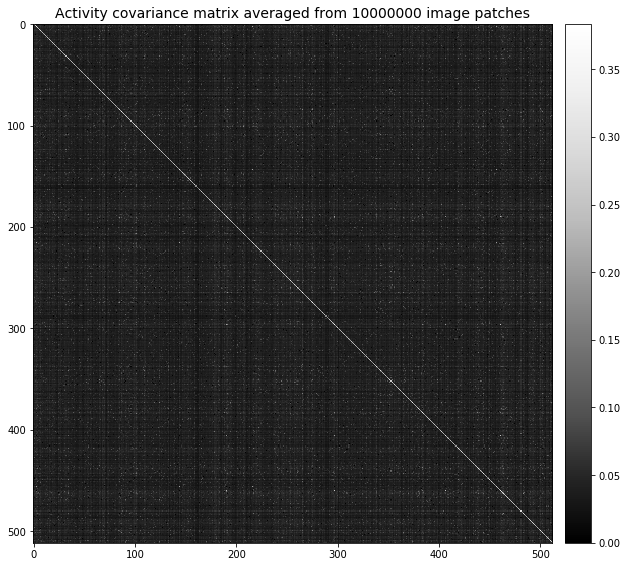

In [8]:
fig = pf.plot_cov_matrix(act_cov, str(params["cov_num_images"]))
fig.savefig(model.disp_dir+"covariance_matrix.png")

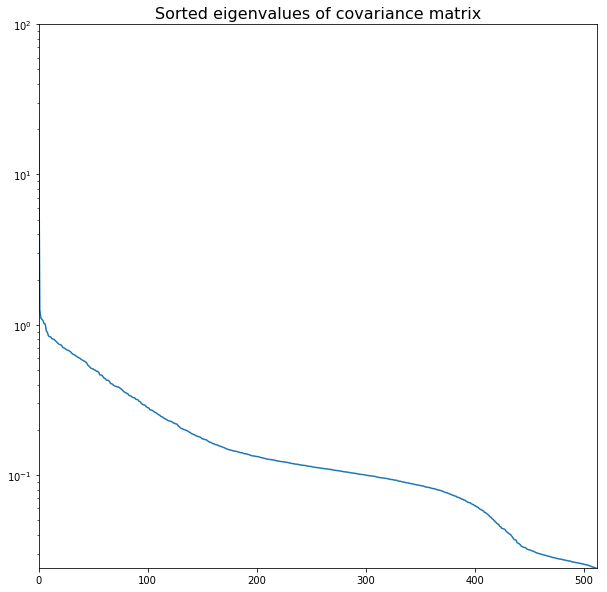

In [9]:
fig = pf.plot_eigenvalues(a_evals, ylim=[0,100])
fig.savefig(model.disp_dir+"eigenvalues.png")

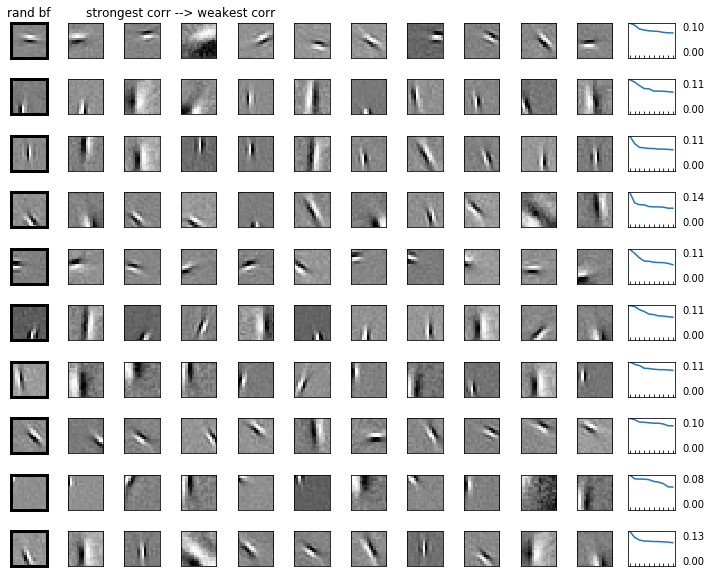

In [10]:
num_random_bases = 10
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(act_cov.shape[0]), num_random_bases)
fig = pf.plot_top_bases(act_cov, weights, bf_indices, num_top_cov_bases)
fig.savefig(model.disp_dir+"top_cov_bases.png")

### Basis function analysis

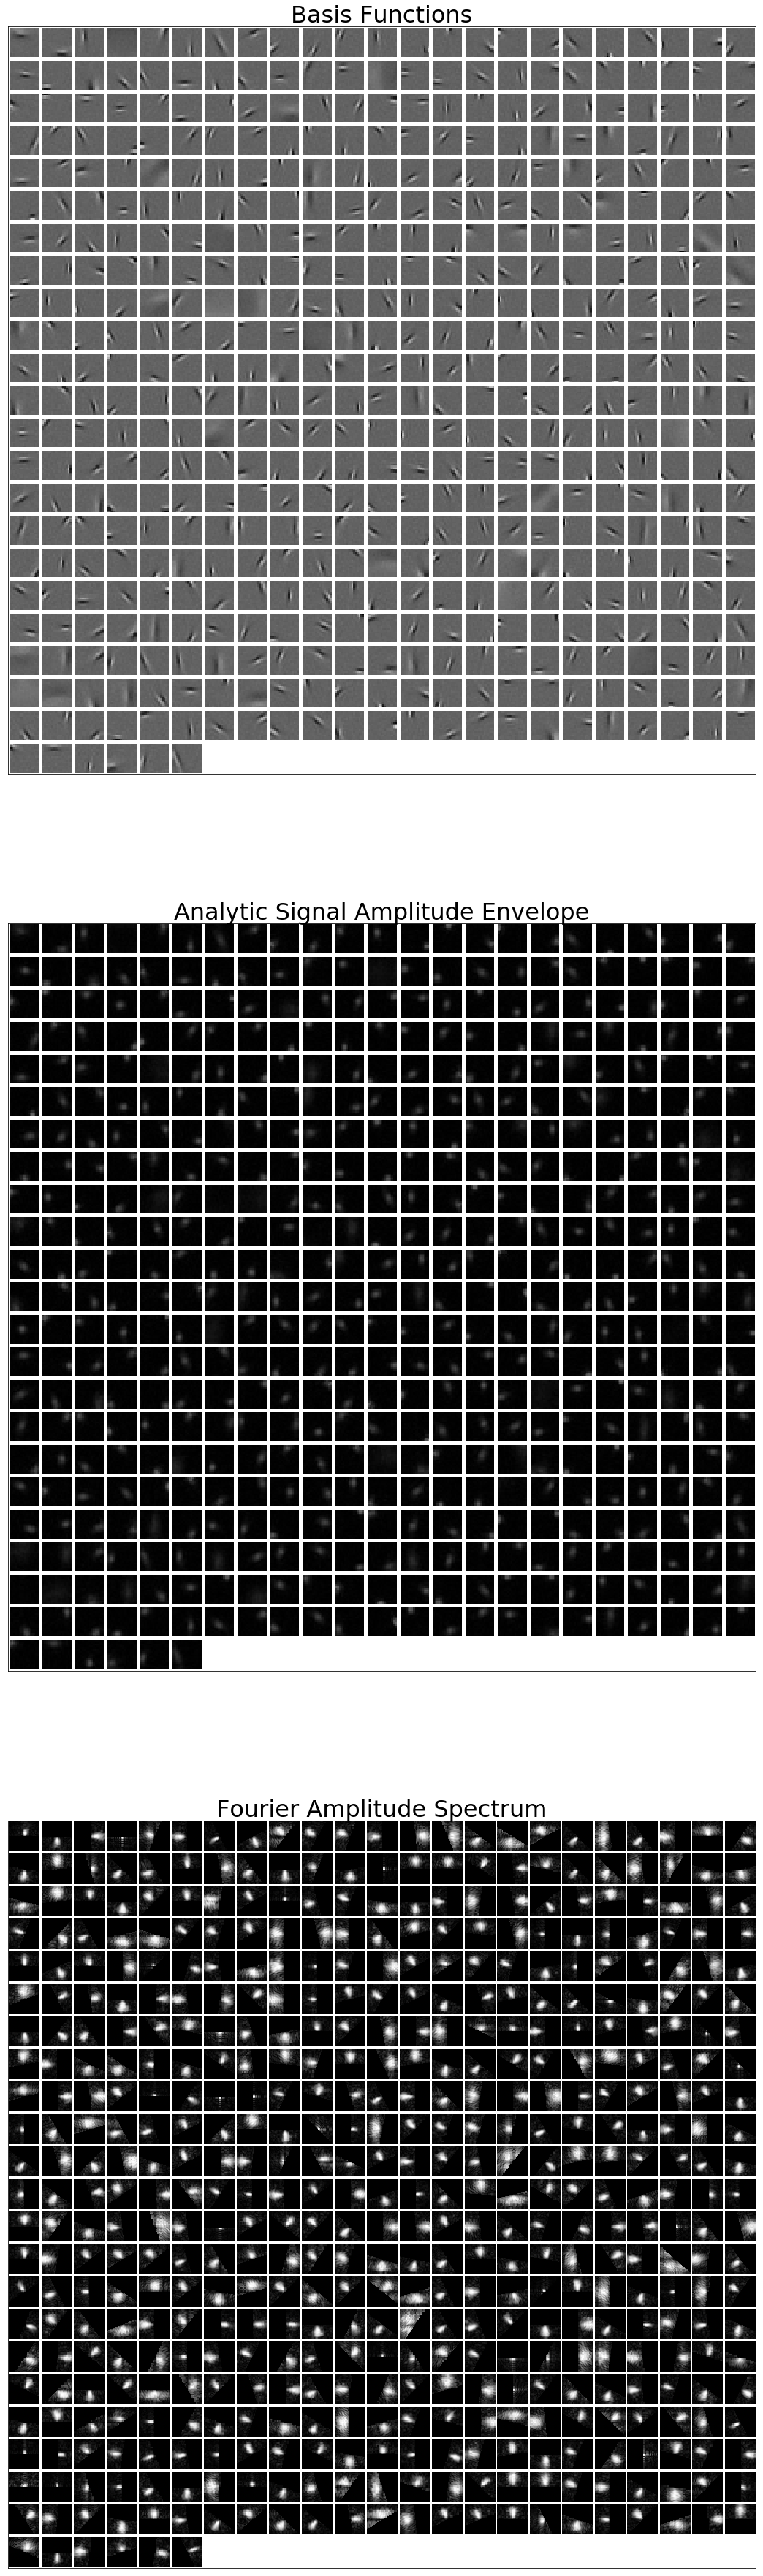

In [11]:
fig = pf.plot_hilbert_analysis(weights, params["ft_padding"])
fig.savefig(model.disp_dir+"hilbert_analysis.png")

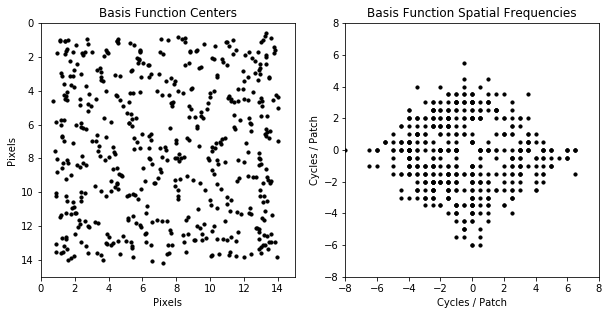

In [12]:
fig = pf.plot_loc_freq_summary(bf_stats)
fig.savefig(model.disp_dir+"location_frequency_centers.png")

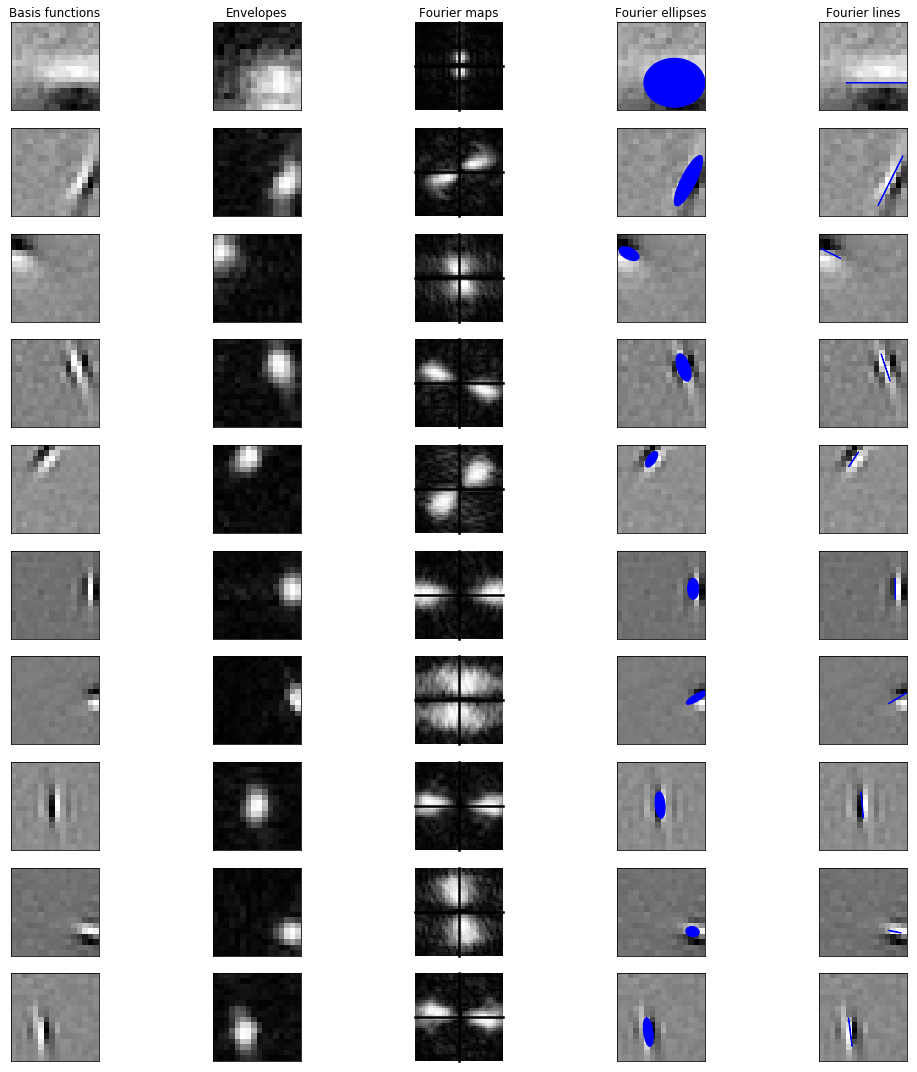

In [13]:
fig = pf.plot_bf_stats(bf_stats, num_bf=10)
fig.savefig(model.disp_dir+"basis_function_summary_stats.png")

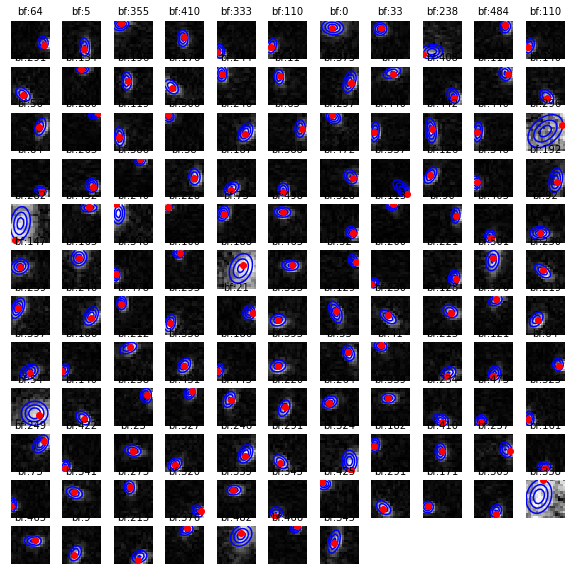

In [14]:
fig = pf.plot_gaussian_contours(bf_stats, num_plots=128)
fig.savefig(model.disp_dir+"gauss_contours.png")

### Pooling and eigen summary plots

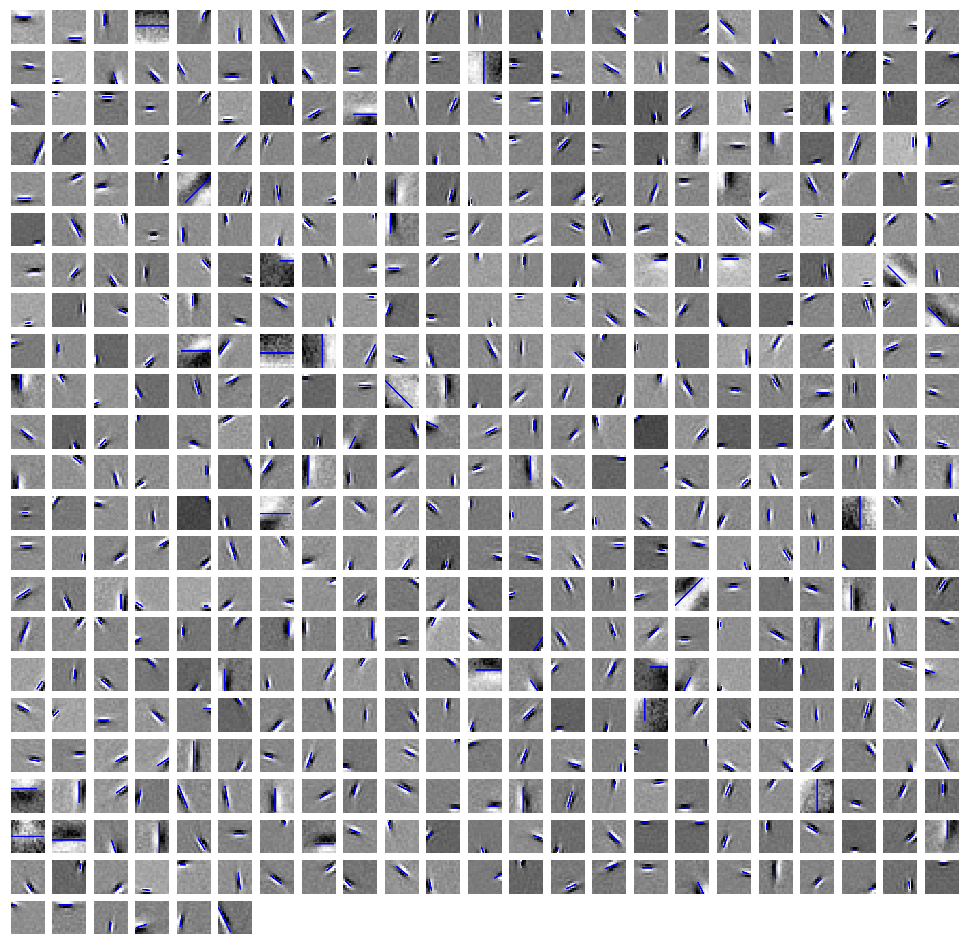

In [15]:
fig = pf.plot_ellipse_summaries(bf_stats, num_bf=1000, lines=True)
fig.savefig(model.disp_dir+"ellipse_fitting_summary.png")

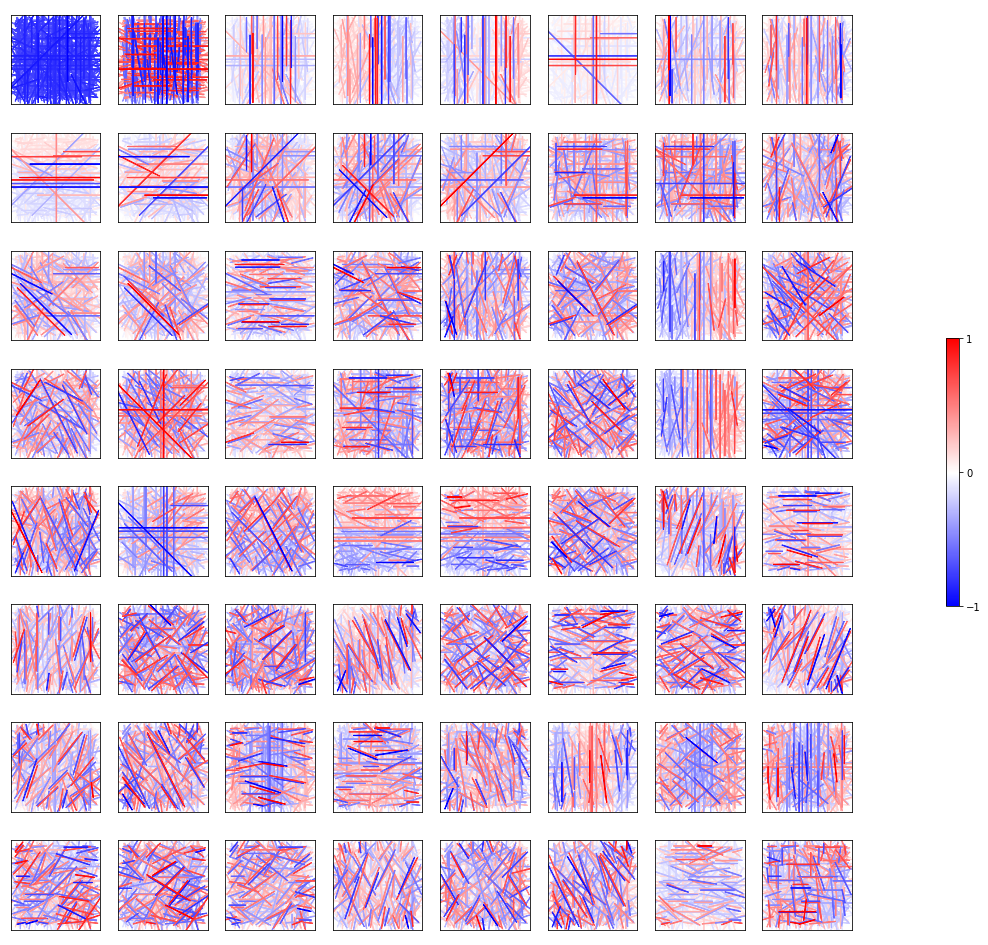

In [16]:
num_pooling_filters = 64 # How many 2nd layer filters to display
num_connected_weights = params["num_neurons"] # How many of strongest connected weight summaries to show
fig = pf.plot_pooling_summaries(bf_stats, a_evecs,
  num_pooling_filters, num_connected_weights, lines=True)
fig.savefig(model.disp_dir+"eigen_pooling_lines.png")

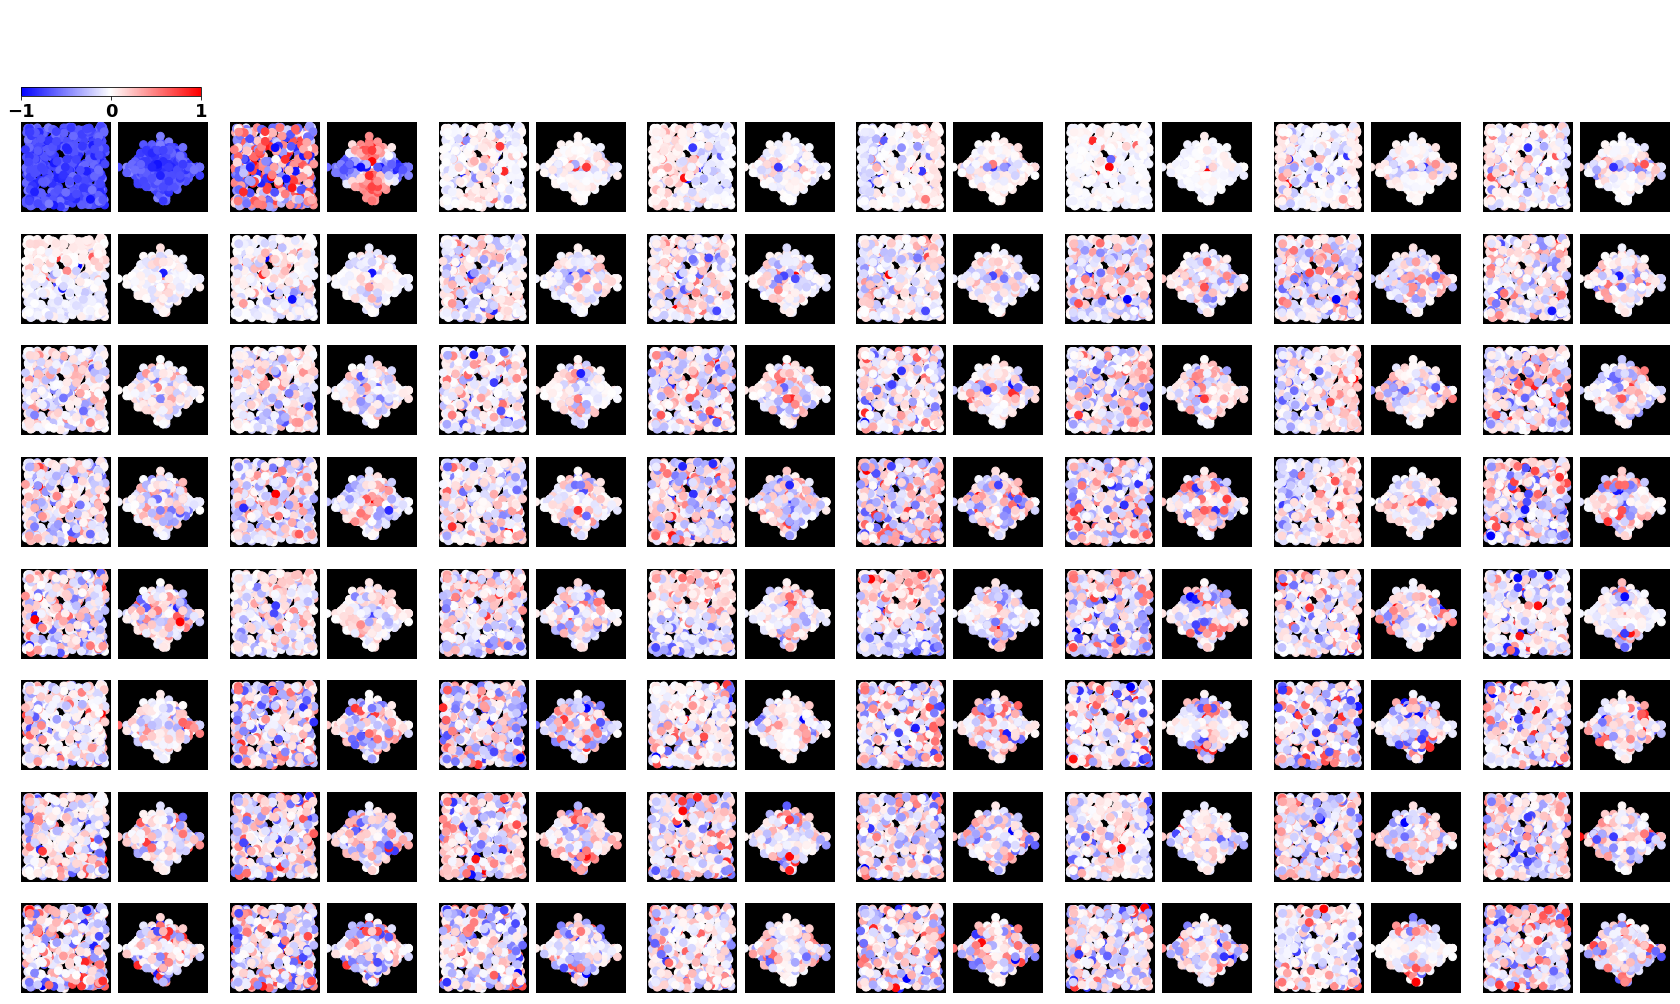

In [17]:
num_pooling_filters = 64
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(bf_stats, a_evecs,
  num_pooling_filters, fig_size, spot_size)
fig.savefig(model.disp_dir+"eigen_pooling_centers.png", bbox_inches="tight")

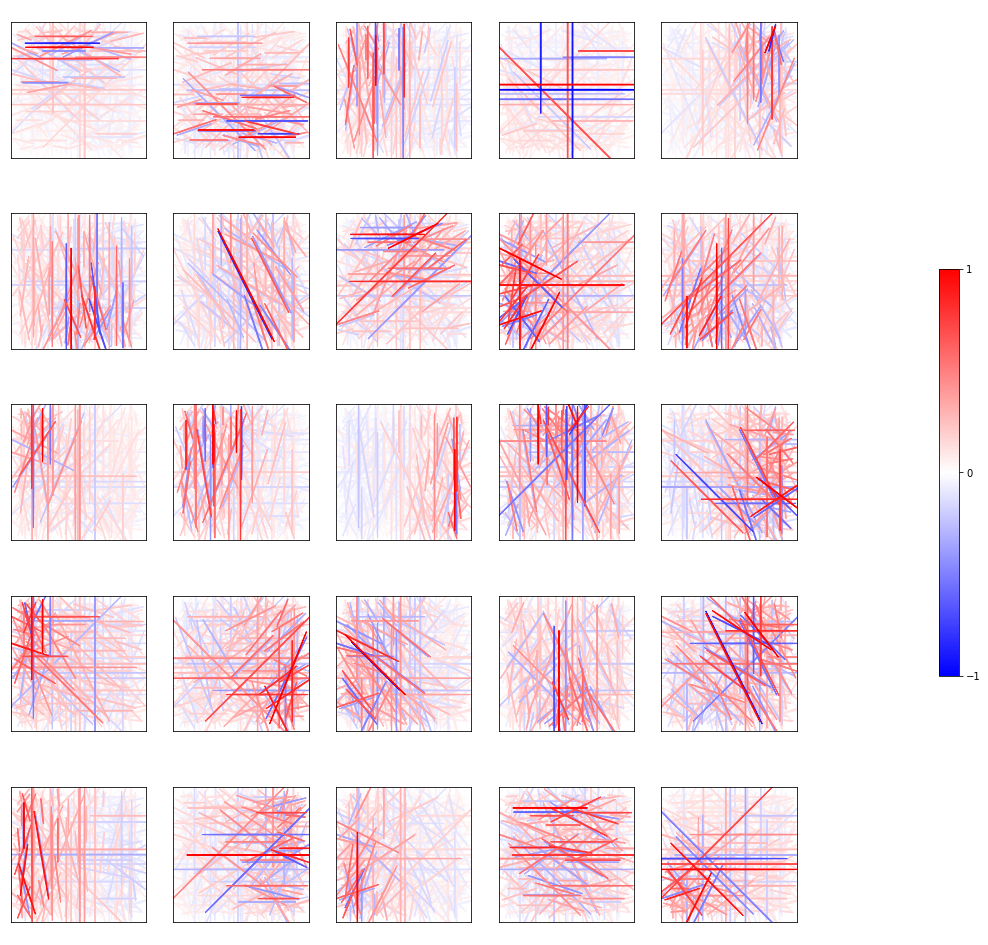

In [18]:
num_pooling_filters = 25
num_connected_weights = params["num_neurons"]
fig = pf.plot_pooling_summaries(bf_stats, pooling_filters, num_pooling_filters,
  num_connected_weights, lines=True)
fig.savefig(model.disp_dir+"reduc_pooling_lines.png")

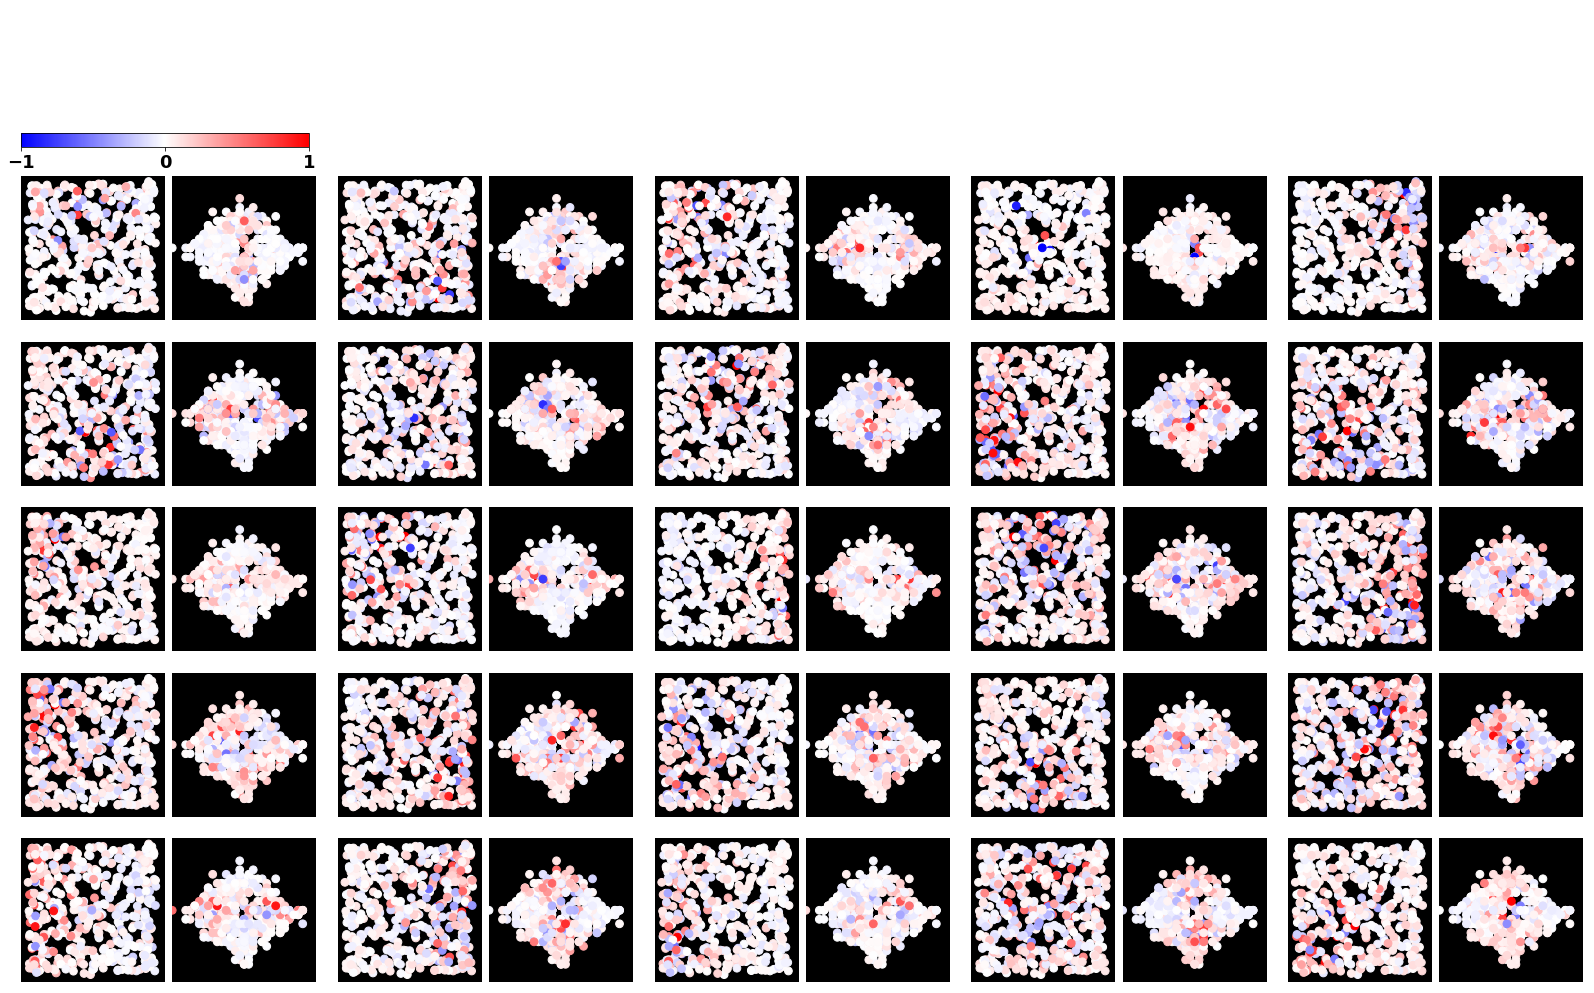

In [19]:
num_pooling_filters = 25
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(bf_stats, pooling_filters, num_pooling_filters,
  fig_size, spot_size)
fig.savefig(model.disp_dir+"reduc_pooling_centers.png", bbox_inches="tight")